<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/transferencia_de_aprendizaje/xception_preentrenado_con_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de aprendizaje y ajuste fino

**Objetivo:** Se busca proveer de una guía en el aprendizaje por transferencia y ajuste fino, dos conceptos conocidos en inglés como *Transfer Learning & Fine-tuning* respectivamente. Se tomará como ejemplo la arquitectura Xception.

## Introducción

***Transfer Learning*** consiste en tomar los patrones aprendidos para resolver un problema y aprovecharlos para resolver otro similar. Por ejemplo, los patrones de un modelo que ya ha aprendido a identificar caballos pueden ser utilizados para entrenar un modelo destinado ahora a reconocer cebras.

El enfoque que propone el aprendizaje por transferencia comúnmente se aplica para tareas en las que el conjunto de datos contiene muy pocos registros para entrenar un modelo a gran escala desde cero.

Por lo general el aprendizaje por transferencia, dentro del contexto del  aprendizaje profundo, mantiene el siguiente flujo de implementación:

1. Se toman las capas de un modelo previamente entrenado para resolver una tarea similar.
2. Se "congelan" las capas del modelo para evitar destruir cualquier información contenida durante futuras iteraciones del entrenamiento.
3. Agregar algunas capas nuevas entrenables sobre las capas previamente congeladas. Éstas aprenderán a actualizar los patrones previos para la generación de predicciones sobre el nuevo conjunto de datos.
4. Entrenar las capas añadidas al conjunto de datos.

Un último paso opcional es el ***fine-tuning***, el cual consiste en descongelar todo el modelo (o parte de él), y volver a entrenarlo en los nuevos datos con una tasa de aprendizaje muy baja. Esto puede potencialmente lograr mejoras significativas al adaptar gradualmente los patrones preentrenadas a los nuevos datos.

Como ejemplo se implementará el flujo tomando un modelo previamente entrenado en el conjunto de datos de *ImageNet* para ahora entrenarlo en la clasificación de un nuevo conjunto de datos de Kaggle "gatos vs perros".

### Librerías

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import layers

#### Congelar capas

Las capas cuentan con tres atributos en relación a los parámetros del modelo:

- `weights`: Es la lista de todas las variables de pesos (parámetros) de la capa.
- `trainable_weights`: Es la lista de aquellos pesos que deben ser actualizados a través de gradiente descendente con el objetivo de minimizar la pérdida durante el entrenamiento.
- `non_trainable_weights`: Es la lista de aquellos pesos que no están destinados a ser entrenados. Por lo general, el modelo los actualiza durante el pase hacia adelante.

In [2]:
# Ejemplo para una capa Densa con 3 unidades
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creación de pesos

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

[INFO] weights: 2
[INFO] trainable_weights: 2
[INFO] non_trainable_weights: 0


En general, todos los pesos son parámetros entrenables. La única capa integrada que tiene pesos no entrenables es la capa `BatchNormalization` ya que utiliza pesos no entrenables para realizar un seguimiento de la media y la varianza de sus entradas durante el entrenamiento.

**Ejemplo:**

In [3]:
layer = tf.keras.layers.BatchNormalization()
layer.build((None, 4))  # Creación de pesos

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

[INFO] weights: 4
[INFO] trainable_weights: 2
[INFO] non_trainable_weights: 2


Las capas de los modelos cuentan también con un atributo booleano `trainable`. Su valor puede ser cambiado. Establecer `layer.trainable` igual a `False` mueve todos los pesos de la capa entrenable a no entrenable, esto se llama "congelar" la capa, es decir, el estado de una capa congelada no será actualizado durante el entrenamiento (ya sea cuando se entrena con `fit()` o cuando se entrena con cualquier bucle personalizado que dependa de `trainable_weights` para aplicar actualizaciones de gradiente).

**Ejemplo:**

In [4]:
layer = tf.keras.layers.Dense(3)
layer.build((None, 4))  # Creación de pesos
layer.trainable = False  # Congelar capas

print("[INFO] weights:", len(layer.weights))
print("[INFO] trainable_weights:", len(layer.trainable_weights))
print("[INFO] non_trainable_weights:", len(layer.non_trainable_weights))

[INFO] weights: 2
[INFO] trainable_weights: 0
[INFO] non_trainable_weights: 2


Cuando un peso entrenable se vuelve no entrenable, su valor ya no se actualiza durante el entrenamiento.

In [6]:
# Definición de un modelo con 2 capas
layer1 = tf.keras.layers.Dense(3, activation="relu")
layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
model = tf.keras.Sequential([tf.keras.Input(shape=(3,)), layer1, layer2])

# Congelar la primera capa
layer1.trainable = False

# Se guarda una copia de los pesos de la capa 1 para referencia posterior
initial_layer1_weights_values = layer1.get_weights()

# Entrenamiento de modelo
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Comprobar que los pesos de la capa 1 no hayan cambiado durante el entrenamiento
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(initial_layer1_weights_values[0], final_layer1_weights_values[0])
np.testing.assert_allclose(initial_layer1_weights_values[1], final_layer1_weights_values[1])

1/1 [==============================] - 3s 3s/step - loss: 0.1215


No confundir el atributo `layer.trainable` con el argumento `training` en `layer.__call__()` (que controla si la capa debe ejecutar su paso hacia adelante en modo de inferencia o modo de entrenamiento).

## Configuración recursiva del atributo `entrenable`

Si establece `trainable = False` en un modelo o en cualquier capa que tenga subcapas, todas las capas hijas también se vuelven no entrenables.

**Ejemplo:**

In [7]:
inner_model = tf.keras.Sequential([tf.keras.Input(shape=(3,)),
                                   tf.keras.layers.Dense(3, activation="relu"),
                                   tf.keras.layers.Dense(3, activation="relu")])

model = tf.keras.Sequential([tf.keras.Input(shape=(3,)), inner_model, tf.keras.layers.Dense(3, activation="sigmoid"),])

model.trainable = False  # Congelar el modelo exterior

assert inner_model.trainable == False  # Todas las capas del modelo ahora están congeladas
assert inner_model.layers[0].trainable == False  # `trainable` se propaga recursivamente

## Ajuste fino de un modelo de clasificación

Para robustecer estos conceptos, se muestra un ejemplo punta a punta. Se cargará el modelo Xception pre-entrenado con ImageNet y se utilizará en el conjunto de datos de clasificación "gatos contra perros" de Kaggle.

### Obtener los datos

Primero, obtengamos el conjunto de datos de gatos contra perros usando TFDS. Transferir el aprendizaje es más útil cuando se trabaja con conjuntos de datos muy pequeños. Para mantener un conjunto de datos pequeño, se utilizará el 40% de los datos de entrenamiento originales (25,000 imágenes) para entrenamiento, 10% para validación y 10% para prueba.

In [8]:
tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
                                             as_supervised=True,
                                             split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"])

print("[INFO] Número de muestras de entrenamiento: %d" % tf.data.experimental.cardinality(train_ds))
print("[INFO] Número de muestras de validación: %d" % tf.data.experimental.cardinality(validation_ds))
print("[INFO] Número de muestras de prueba: %d" % tf.data.experimental.cardinality(test_ds))

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
[INFO] Número de muestras de entrenamiento: 9305
[INFO] Número de muestras de validación: 2326
[INFO] Número de muestras de prueba: 2326


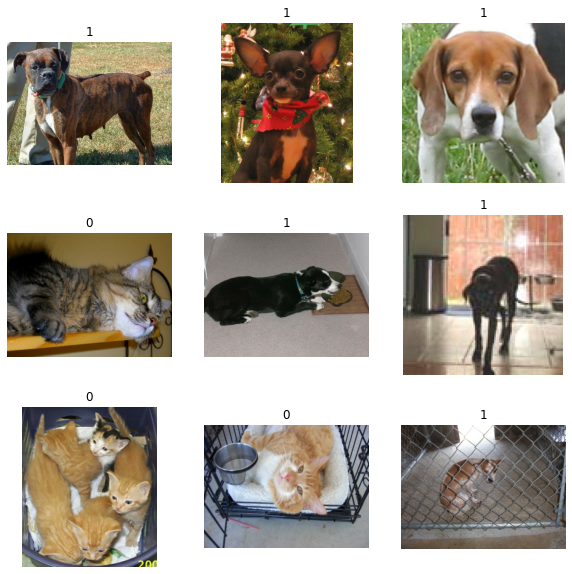

In [9]:
# Primeras 9 imágenes en el conjunto de datos de entrenamiento
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

Se puede identificar que todas las imágenes tienen distintos tamaños.

También que la etiqueta 1 se asigna a la categoría "perro" y la etiqueta 0 se asigna a la clase "gato".

### Estandarización de datos

Las imágenes del conjunto de datos cuentan con una amplia variedad de tamaños. Además, cada pixel consta de 3 enteros valores entre 0 y 255 (valores de nivel RGB). Esto no es muy adecuado para alimentar una red neuronal, por lo tanto, se deben aplicar 2 transformaciones:

- Estandarizar a un tamaño de imagen fijo como por ejemplo, 150x150
- Normalizar los valores de cada pixel entre -1 y 1.

En general, es una buena práctica desarrollar modelos que tomen datos sin procesar como entrada, a diferencia de los modelos que toman datos ya preprocesados, la razón es que, si el modelo espera recibir datos preprocesados, cada vez que se exporta el modelo para usarlo en otro entorno, como por ejemplo en un navegador web o en una aplicación móvil, se deberá volver a implementar exactamente el mismo *pipeline* de preprocesamiento. Esto se vuelve complejo rápidamente, así que se debería hacer la mínima cantidad posible de preprocesamiento antes de llegar al modelo.


In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Se agrupan los datos por lotes y se utiliza el almacenamiento en caché y se transfieren datos de la memoria principal al almacenamiento temporal para que estén listos para su uso posterior (*prefetch*), para optimizar la velocidad de carga.

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Aumentación de datos

Cuando no se tiene un conjunto de datos de imágenes grande, es una buena práctica introducir sintéticamente diversidad de muestras aplicando transformaciones (pero realistas) a las imágenes de entrenamiento, como cambios horizontales o pequeñas rotaciones. Esto ayuda a exponer al modelo a diferentes aspectos de los datos de entrenamiento mientras reduce el sobreajuste.

In [12]:
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),])

Se visualiza la primera imagen del primer lote después de varias transformaciones aleatorias:

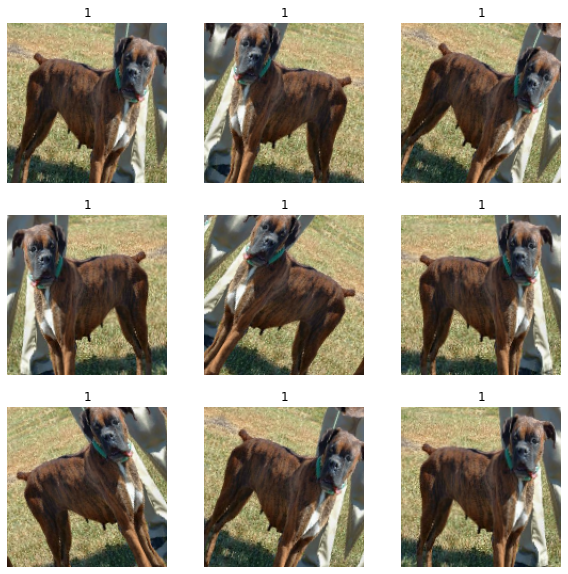

In [13]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Arquitectura de Modelo

Se construye un modelo que siga las características detalladas anteriormente. Tener en cuenta que dentro de la arquitectura:

- Se agrega una capa de `Rescaling` para escalar los valores de entrada (inicialmente en el rango [0, 255]) al rango [-1, 1].
- Se agrega una capa `Dropout` para añadir regularización.
- Importante asegurarse de establecer la configuración `training=False` al llamar al modelo base. Esto para que se ejecute en modo inferencia.

In [14]:
base_model = tf.keras.applications.Xception(weights="imagenet",  # Pesos previamente entrenados en ImageNet
                                            input_shape=(150, 150, 3),
                                            include_top=False)
# No incluir el clasificador ImageNet en la parte superior
# (donde la capa de entrada se ubica en la parte inferior)

# Congelar el modelo base
base_model.trainable = False

# Parte superior del modelo (capas de salida)
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Aplica aumentación de datos

# Los pesos de Xception preentrenados requieren que la entrada se re-escale
# Salidas: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# El modelo base contiene capas de normas por lotes (batchnorm).
# Se busca mantenerlos en modo de inferencia cuando se descongela
# el modelo base para entrenarlo, así se asegura que 
# se está ejecutando en modo de inferencia
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

### Entrenamiento

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [16]:
%%time
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 40s 109ms/step - loss: 0.1554 - binary_accuracy: 0.9354 - val_loss: 0.0812 - val_binary_accuracy: 0.9690
Epoch 2/20
291/291 [==============================] - 27s 94ms/step - loss: 0.1160 - binary_accuracy: 0.9501 - val_loss: 0.0760 - val_binary_accuracy: 0.9703
Epoch 3/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1046 - binary_accuracy: 0.9558 - val_loss: 0.0735 - val_binary_accuracy: 0.9699
Epoch 4/20
291/291 [==============================] - 28s 95ms/step - loss: 0.1046 - binary_accuracy: 0.9600 - val_loss: 0.0700 - val_binary_accuracy: 0.9742
Epoch 5/20
291/291 [==============================] - 26s 89ms/step - loss: 0.1054 - binary_accuracy: 0.9565 - val_loss: 0.0707 - val_binary_accuracy: 0.9729
Epoch 6/20
291/291 [==============================] - 26s 90ms/step - loss: 0.0978 - binary_accuracy: 0.9612 - val_loss: 0.0769 - val_binary_accuracy: 0.9708
Epoch 7/20
291/291 [==============================]

## Ajuste fino

Finalmente, se 'descongela' el modelo base y se entrena todo el modelo de principio a fin con una tasa de aprendizaje baja.

Es importante destacar que, aunque el modelo base se vuelve entrenable, todavía se ejecuta en modo de inferencia ya que pasamos a `training=False` cuando se llama al modelo. Esto significa que las capas de normalización de lotes (batchnorm) no actualizarán sus estadígrafos. Si lo hicieran, causarían estragos en las representaciones aprendidas por el modelo hasta el momento.

In [17]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje baja
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [19]:
%%time
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 104s 325ms/step - loss: 0.0756 - binary_accuracy: 0.9678 - val_loss: 0.0607 - val_binary_accuracy: 0.9781
Epoch 2/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0559 - binary_accuracy: 0.9776 - val_loss: 0.0615 - val_binary_accuracy: 0.9776
Epoch 3/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0467 - binary_accuracy: 0.9821 - val_loss: 0.0492 - val_binary_accuracy: 0.9824
Epoch 4/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0370 - binary_accuracy: 0.9862 - val_loss: 0.0480 - val_binary_accuracy: 0.9824
Epoch 5/10
291/291 [==============================] - 92s 316ms/step - loss: 0.0281 - binary_accuracy: 0.9893 - val_loss: 0.0511 - val_binary_accuracy: 0.9811
Epoch 6/10
291/291 [==============================] - 92s 317ms/step - loss: 0.0214 - binary_accuracy: 0.9913 - val_loss: 0.0457 - val_binary_accuracy: 0.9824
Epoch 7/10
291/291 [=========================

Después de tan solo 10 épocas, el ajuste fino brinda una efectividad razonablemente buena.

**Referencias**

* https://paperswithcode.com/method/xception
* https://paperswithcode.com/method/depthwise-separable-convolution
